#MSM of the alanine dipeptide

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj

In [3]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


In [4]:
tr.discretize(states=['A', 'E'])
tr.find_keys()

In [5]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr])


 Building MSM from 
[['data/protein_only.xtc']]
     # states: 2


In [6]:
for i in [1, 2, 5, 7, 10, 20, 50, 100]:
    msm_alaTB.do_msm(i)
    msm_alaTB.msms[i].do_trans()
    #msm_alaTB.msms[i].boots(plot=False)

The method produces acceptable solutions for short lag times although the result rapidly diverges from the transition matrix relaxation time at long lag times. The rate matrix elements have the following values:

In [7]:
msm_alaTB.msms[1].do_rate()
msm_alaTB.msms[1].rate

array([[-0.01251929,  0.01726619],
       [ 0.01251929, -0.01726619]])

Alternatively, we can use the lifetime based method, where we use branching probabilities and average lifetimes. The rate is almost identical to that from the Taylor expansion.

In [8]:
msm_alaTB.do_lbrate()
print msm_alaTB.lbrate

[[-0.01251929  0.01730769]
 [ 0.01251929 -0.01730769]]


Finally, we use Buchete and Hummer's maximum likelihood propagator-based method, which is also implemented in MasterMSM.

In [52]:
msm_alaTB.msms[1].do_rate(method='MLPB')

[[-0.01251929  0.01726619]
 [ 0.01251929 -0.01726619]]


[[-0.0127083   0.03637988]
 [ 0.0127083  -0.03637988]]
755.947964992 755.939781227


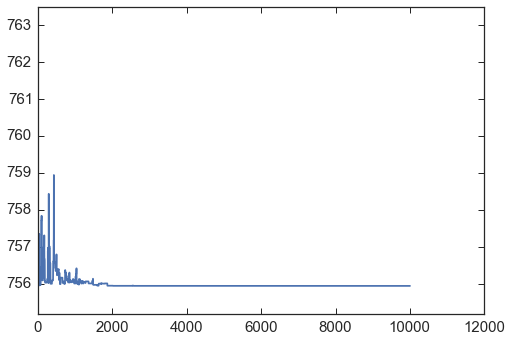

In [53]:
print msm_alaTB.msms[1].rate
fig,ax = plt.subplots()
ax.plot(msm_alaTB.msms[1].ml)
ax.set_ylim(np.min(msm_alaTB.msms[1].ml)*0.999,np.median(msm_alaTB.msms[1].ml)*1.01)
print msm_alaTB.msms[1].ml[0], msm_alaTB.msms[1].ml[-1]